# Delta Hedging an Option as a Trading Strategy

## The Black-Scholes Model
The Black-Scholes model is a mathematical framework for pricing European options. It assumes that the price of the underlying asset follows a Geometric Brownian Motion (GBM) with constant drift and volatility.

The Black-Scholes formula for a European call option is:

$$
C(S, t) = S N(d_1) - Ke^{-r(T-t)} N(d_2)
$$

where:

- $ S $ = Current stock price
- $ K $ = Strike price
- $ T $ = Time to expiration
- $ r $ = Risk-free rate
- $ \sigma $ = Volatility
- $ N(d) $ = CDF of the standard normal distribution
- $ d_1 = \frac{\ln(S/K) + (r + \sigma^2/2)(T-t)}{\sigma \sqrt{T-t}} $
- $ d_2 = d_1 - \sigma \sqrt{T-t} $

Next, we'll implement the Black-Scholes formula in Python.


In [1]:
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt

# Black-Scholes pricing function for a European Call option
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * si.norm.cdf(d1) - K * np.exp(-r * T) * si.norm.cdf(d2)
    delta = si.norm.cdf(d1)  # Delta of the call option
    return call_price, delta

In [2]:
%pip install ipywidgets
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive

# Function to update the plot
def update(K=100, T=1, r=0.05, sigma=0.2):
    S_range = np.linspace(50, 150, 100)
    prices = []
    deltas = []
    
    for s in S_range:
        price, delta = black_scholes_call(s, K, T, r, sigma)
        prices.append(price)
        deltas.append(delta)
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    ax1.plot(S_range, prices, 'b-', label='Option Price')
    ax2.plot(S_range, deltas, 'r-', label='Delta')
    
    ax1.set_xlabel('Stock Price (S)')
    ax1.set_ylabel('Option Price', color='b')
    ax2.set_ylabel('Delta', color='r')
    
    ax1.tick_params(axis='y', colors='b')
    ax2.tick_params(axis='y', colors='r')
    
    plt.title('Black-Scholes Option Pricing & Delta')
    plt.show()

# Create interactive sliders
interactive_plot = interactive(update, 
                               K=widgets.FloatSlider(min=50, max=150, step=1, value=100, description='K'),
                               T=widgets.FloatSlider(min=0.1, max=5, step=0.1, value=1, description='T'),
                               r=widgets.FloatSlider(min=0, max=0.2, step=0.01, value=0.05, description='r'),
                               sigma=widgets.FloatSlider(min=0.05, max=1, step=0.05, value=0.2, description='sigma'))

interactive_plot

Note: you may need to restart the kernel to use updated packages.


interactive(children=(FloatSlider(value=100.0, description='K', max=150.0, min=50.0, step=1.0), FloatSlider(va…

## Geometric Brownian Motion
Geometric Brownian Motion (GBM) models stock price evolution as:

$$
dS_t = \mu S_t dt + \sigma S_t dW_t
$$

where:
- $ \mu $ = Drift (expected return)
- $ \sigma $ = Volatility
- $ dW_t $ = Wiener process

We will now define a function to simulate a stock price path using GBM.


In [3]:
def simulate_gbm(S0, mu, sigma, T, dt=1/252):
    """Simulates a Geometric Brownian Motion (GBM) price path."""
    n_steps = int(T / dt)
    t = np.linspace(0, T, n_steps)
    W = np.random.standard_normal(size=n_steps)
    W = np.cumsum(W) * np.sqrt(dt)  # Wiener process
    S_t = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)
    return S_t, t

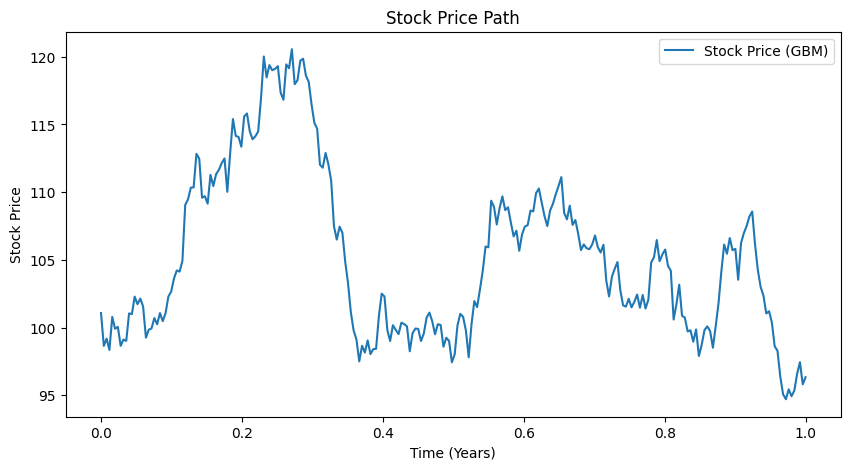

In [4]:
# Example Parameters
S0, K, T, r, sigma, mu = 100, 100, 1, 0.05, 0.2, 0.08

# Run single delta hedge simulation
S_t, t = simulate_gbm(S0, mu, sigma, T)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(t, S_t, label="Stock Price (GBM)")
plt.title("Stock Price Path")
plt.xlabel("Time (Years)")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


## Delta Hedging a Short Call
The delta-hedging strategy consists of:
1. Selling a European call option at the Black-Scholes price.
2. Buying a dynamically adjusted amount of stock to hedge the delta exposure.
3. Rebalancing the hedge throughout the life of the option.
4. Calculating the realized profit/loss at expiration.

The function below simulates the delta-hedging process.


In [5]:
def delta_hedge_simulation(S0, K, T, r, sigma, mu, dt=1/252):
    """Simulates a delta hedging strategy for a short call position."""
    # Generate GBM path
    S_t, t = simulate_gbm(S0, mu, sigma, T, dt)
    
    # Initial Black-Scholes price
    call_price, delta = black_scholes_call(S0, K, T, r, sigma)
    
    # Short the call, buy delta shares
    initial_cash = call_price - delta * S0  # Initial cash position
    portfolio_value = initial_cash
    deltas = [delta]
    
    # Iterate over time steps to rebalance hedge
    for i in range(1, len(S_t)):
        tau = T - i * dt  # Time remaining
        call_price, delta = black_scholes_call(S_t[i], K, tau, r, sigma)
        deltas.append(delta)
        
        # Portfolio value at each step
        portfolio_value = delta * S_t[i] + initial_cash * np.exp(r * i * dt)

    # Final profit/loss
    final_pnl = portfolio_value - max(S_t[-1] - K, 0)  # Payoff of the short call
    return S_t, final_pnl, deltas, t


Option Price |  10.450583572185565  | Initial Delta |  0.6368306511756191


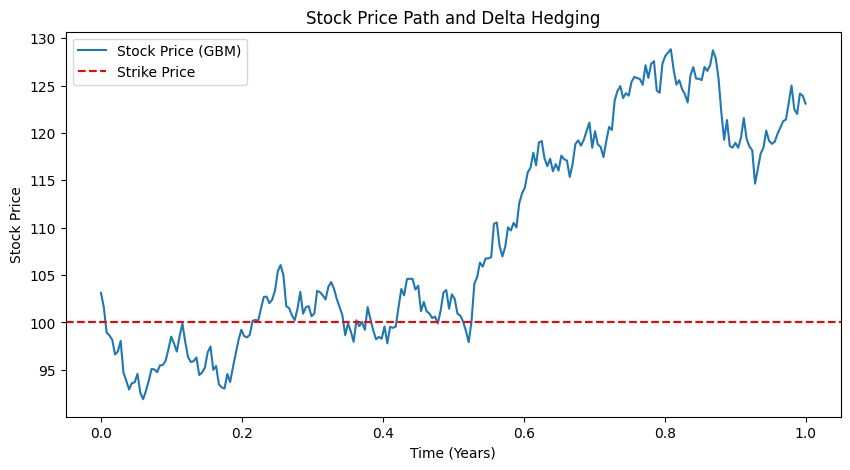

Final P&L from Delta Hedging: 44.05


In [6]:
# Example Parameters
S0, K, T, r, sigma, mu = 100, 100, 1, 0.05, 0.2, 0.08

ex = black_scholes_call(S0, K, T, r, sigma)

print('Option Price | ', ex[0], ' | Initial Delta | ', ex[1])

# Run single delta hedge simulation
S_t, final_pnl, deltas, t = delta_hedge_simulation(S0, K, T, r, sigma, mu)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(t, S_t, label="Stock Price (GBM)")
plt.axhline(K, color='r', linestyle="--", label="Strike Price")
plt.title("Stock Price Path and Delta Hedging")
plt.xlabel("Time (Years)")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

print(f"Final P&L from Delta Hedging: {final_pnl:.2f}")


## Monte Carlo Simulation
To analyze the effectiveness of delta hedging, we run the simulation 1000 times and compute the average P/L.


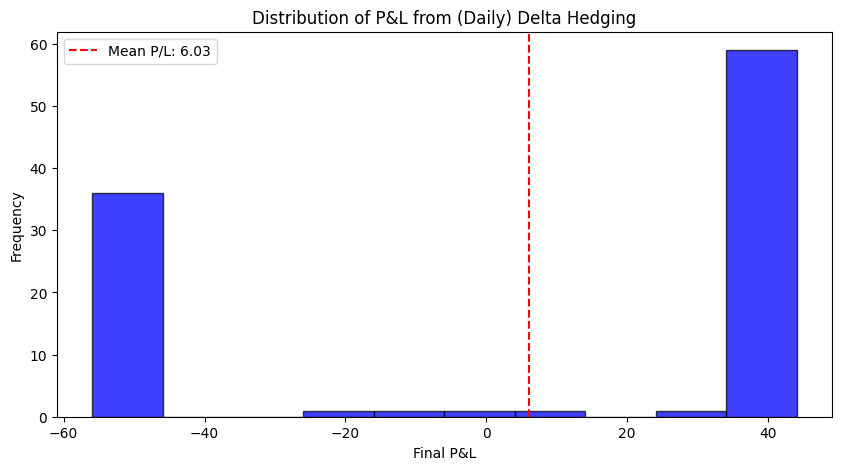

Average P&L over 100 simulations: 6.03


In [7]:
n_simulations = 100
pnl_results = []

for _ in range(n_simulations):
    _, final_pnl, _, _ = delta_hedge_simulation(S0, K, T, r, sigma, mu)
    pnl_results.append(final_pnl)

# Plot histogram of outcomes
plt.figure(figsize=(10, 5))
plt.hist(pnl_results, bins=10, alpha=0.75, color="blue", edgecolor="black")
plt.axvline(np.mean(pnl_results), color='r', linestyle="--", label=f"Mean P/L: {np.mean(pnl_results):.2f}")
plt.title("Distribution of P&L from (Daily) Delta Hedging")
plt.xlabel("Final P&L")
plt.ylabel("Frequency")
plt.legend()
plt.show()

print(f"Average P&L over {n_simulations} simulations: {np.mean(pnl_results):.2f}")


### Convergence to Theoretical Price

As per the argument made in their 1973 paper, should the discretization and hedging approach continuous time the expectation of P/L will converge to the theoreical price imposed by the Black-Scholes model.

In [8]:
def delta_hedge_simulation(S0, K, T, r, sigma, mu, dt=1/1000):
    """Simulates a delta hedging strategy for a short call position."""
    # Generate GBM path
    S_t, t = simulate_gbm(S0, mu, sigma, T, dt)
    
    # Initial Black-Scholes price
    call_price, delta = black_scholes_call(S0, K, T, r, sigma)
    
    # Short the call, buy delta shares
    initial_cash = call_price - delta * S0  # Initial cash position
    portfolio_value = initial_cash
    deltas = [delta]
    
    # Iterate over time steps to rebalance hedge
    for i in range(1, len(S_t)):
        tau = T - i * dt  # Time remaining
        call_price, delta = black_scholes_call(S_t[i], K, tau, r, sigma)
        deltas.append(delta)
        
        # Portfolio value at each step
        portfolio_value = delta * S_t[i] + initial_cash * np.exp(r * i * dt)

    # Final profit/loss
    final_pnl = portfolio_value - max(S_t[-1] - K, 0)  # Payoff of the short call
    return S_t, final_pnl, deltas, t


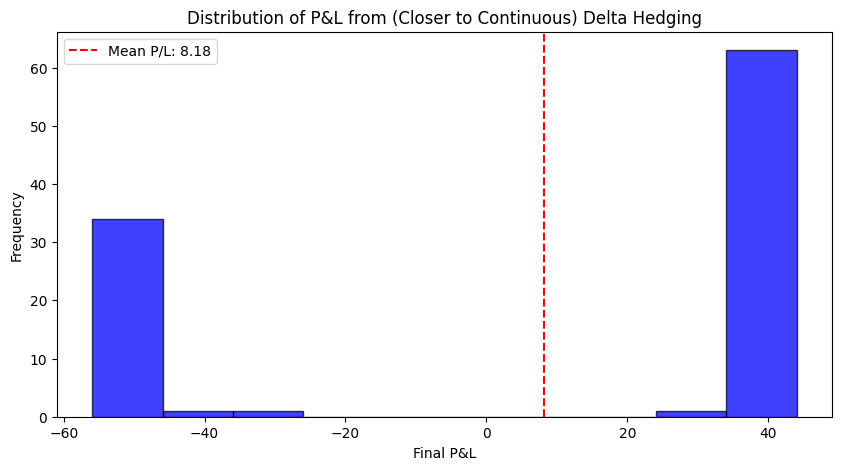

Average P&L over 100 simulations: 8.18


In [9]:
n_simulations = 100
pnl_results = []

for _ in range(n_simulations):
    _, final_pnl, _, _ = delta_hedge_simulation(S0, K, T, r, sigma, mu)
    pnl_results.append(final_pnl)

# Plot histogram of outcomes
plt.figure(figsize=(10, 5))
plt.hist(pnl_results, bins=10, alpha=0.75, color="blue", edgecolor="black")
plt.axvline(np.mean(pnl_results), color='r', linestyle="--", label=f"Mean P/L: {np.mean(pnl_results):.2f}")
plt.title("Distribution of P&L from (Closer to Continuous) Delta Hedging")
plt.xlabel("Final P&L")
plt.ylabel("Frequency")
plt.legend()
plt.show()

print(f"Average P&L over {n_simulations} simulations: {np.mean(pnl_results):.2f}")


### Long Story Short

Our expected P/L conducting a delta hedging scheme that approaches continuous time is simply the premium we collect for the call.

### Applied Example: Opinion on Volatility

Should we have an opinion on the parameterization of the dynamics of the underlying asset then we can conduct a "statistical arbitrage" by delta hedging.

In [10]:
def delta_hedge_simulation(S0, K, T, r, sigma, mu, dt=1/500, vol_pos=None):
    """Simulates a delta hedging strategy for a short call position."""
    # Initial Black-Scholes price capturing market opinion
    call_price, delta = black_scholes_call(S0, K, T, r, sigma)
    
    if vol_pos != None:
        sigma = vol_pos
    
    # Generate GBM path according to our vol opinion
    S_t, t = simulate_gbm(S0, mu, sigma, T, dt)
    
    
    
    # Short the call, buy delta shares
    initial_cash = call_price - delta * S0  # Initial cash position
    portfolio_value = initial_cash
    deltas = [delta]
    
    # Iterate over time steps to rebalance hedge
    for i in range(1, len(S_t)):
        tau = T - i * dt  # Time remaining
        call_price, delta = black_scholes_call(S_t[i], K, tau, r, sigma)
        deltas.append(delta)
        
        # Portfolio value at each step
        portfolio_value = delta * S_t[i] + initial_cash * np.exp(r * i * dt)

    # Final profit/loss
    final_pnl = portfolio_value - max(S_t[-1] - K, 0)  # Payoff of the short call
    return S_t, final_pnl, deltas, t


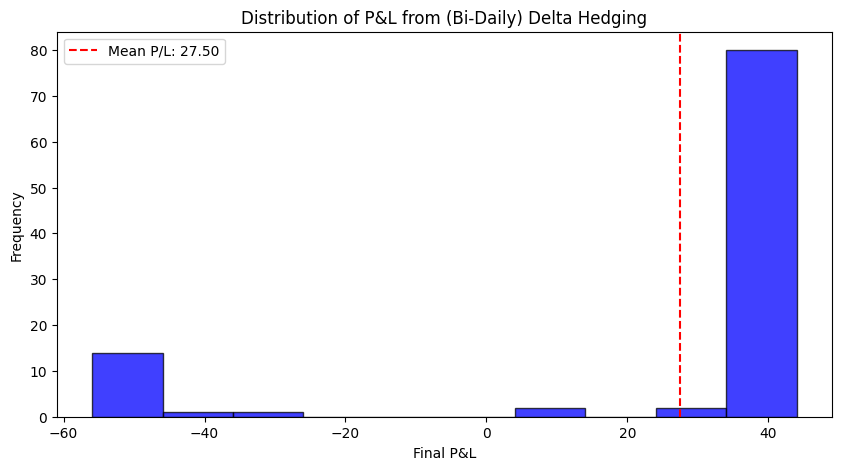

Average P&L over 100 simulations: 27.50


In [11]:
n_simulations = 100
pnl_results = []

for _ in range(n_simulations):
    _, final_pnl, _, _ = delta_hedge_simulation(S0, K, T, r, sigma, mu, vol_pos=.1)
    pnl_results.append(final_pnl)

# Plot histogram of outcomes
plt.figure(figsize=(10, 5))
plt.hist(pnl_results, bins=10, alpha=0.75, color="blue", edgecolor="black")
plt.axvline(np.mean(pnl_results), color='r', linestyle="--", label=f"Mean P/L: {np.mean(pnl_results):.2f}")
plt.title("Distribution of P&L from (Bi-Daily) Delta Hedging")
plt.xlabel("Final P&L")
plt.ylabel("Frequency")
plt.legend()
plt.show()

print(f"Average P&L over {n_simulations} simulations: {np.mean(pnl_results):.2f}")

# Key Takeaways
- **Delta hedging** helps offset the risk of a short call position, but is not perfect due to discrete rebalancing.
- **Monte Carlo simulations** reveal the distribution of possible P/L outcomes.
- **The strategy's effectiveness** depends on how well Black-Scholes assumptions hold in real markets.

This notebook provides a clear framework for testing and analyzing delta hedging strategies under different conditions. 🚀
